<a href="https://colab.research.google.com/github/araldi/HS21---Big-Data-Analysis-in-Biomedical-Research-376-1723-00L-/blob/main/Week6/LinearModels_part2_solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multivariate linear regression



### Categorical variables

In the formulas, you can specify quantitative and categorical variables with the notation:


```
'y ~ C(name_cat_variable) + Q("name_quant_variable")'
```
(note the double use of " and ')

If you want to specify which one of the categorical variables is your reference variable (the one from which all the computations will be made), then specify it in the levels. The first level will be the reference.

```
'y ~ C(name_cat_variable, levels = [reference_category, category1, category2, category3, ...) + Q("name_quant_variable")'
```

Or you can use OneHotEncoding to transform categorical variables into individual columns.

```
from sklearn import preprocessing
enc = preprocessing.OneHotEncoder()
enc.fit(df[['column_to_encode']])
one_hot = enc.transform(df[['column_to_encode']]).toarray()
df[enc.categories_] = one_hot
```




### Feature engineering

Within the linear model, you can define in the formula further interactions among predictor variables using the patsy notation in statsmodels.formula.api. Below there is the explanation of the formula symbols.

#### Formulas with patsy
**~**

Separates the left-hand side and right-hand side of a formula. Optional. If not present, then the formula is considered to contain a right-hand side only.


**+**  
Takes the set of terms given on the left and the set of terms given on the right, and returns a set of terms that combines both (i.e., it computes a set union). Note that this means that a + a is just a

**:**

This takes two sets of terms, and computes the interaction between each term on the left and each term on the right. So, for example, (a + b):(c + d) is the same as a:c + a:d + b:c + b:d. Calculating the interaction between two terms is also a kind of set union operation, but : takes the union of factors within two terms, while + takes the union of two sets of terms. Note that this means that a:a is just a, and (a:b):(a:c) is the same as a:b:c.

**\***  

a \* b is short-hand for a + b + a:b, and is useful for the common case of wanting to include all interactions between a set of variables while partitioning their variance between lower- and higher-order interactions. Standard ANOVA models are of the form a * b * c * ....



**/**

a / b is shorthand for a + a:b, and is intended to be useful in cases where you want to fit a standard sort of ANOVA model, but b is nested within a, so a*b doesn’t make sense. So far so good. Also, if you have multiple terms on the right, then the obvious thing happens: a / (b + c) is equivalent to a + a:b + a:c (/ is rightward distributive over +). But, if you have multiple terms on the left, then there is a surprising special case: (a + b)/c is equivalent to a + b + a:b:c (and note that this is different from what you’d get out of a/c + b/c – / is not leftward distributive over +). Again, this is motivated by the idea of using this for nested variables. It doesn’t make sense for c to be nested within both a and b separately, unless b is itself nested in a – but if that were true, then you’d write a/b/c instead. So if we see (a + b)/c, we decide that a and b must be independent factors, but that c is nested within each combination of levels of a and b, which is what a:b:c gives us. 

**\*\***

This takes a set of terms on the left, and an integer n on the right, and computes the * of that set of terms with itself n times. This is useful if you want to compute all interactions up to order n, but no further.

[link text](https://patsy.readthedocs.io/en/latest/formulas.html
)



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Predict insurance charges

Explore the dataset and plot the most relevant parameters to find which predictor variables to use for the linear model.

In [ ]:
medical_charges_url = 'https://raw.githubusercontent.com/JovianML/opendatasets/master/data/medical-charges.csv'
medical_charges= pd.read_csv(medical_charges_url)

In [ ]:
medical_charges

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [ ]:
medical_charges.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [ ]:
# check if there are missing values
medical_charges.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Text(0, 0.5, 'Individuals [counts]')

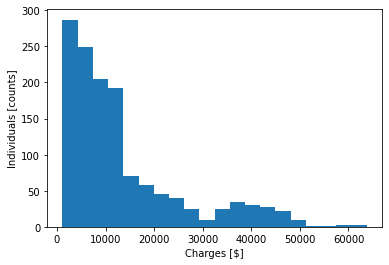

In [ ]:
plt.hist(medical_charges['charges'], bins =20)
plt.xlabel('Charges [$]')
plt.ylabel('Individuals [counts]')

### Exercise 1
 
Plot the relationship between charges and all the other features.
What is the correlation of all the features?

Text(0, 0.5, 'Individuals [counts]')

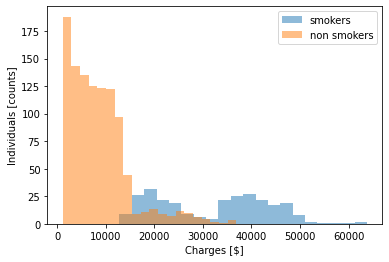

In [ ]:
smokers = medical_charges['smoker'] == 'yes'
nonsmokers = medical_charges['smoker'] == 'no'
plt.hist(medical_charges[smokers]['charges'], bins =20, label = 'smokers', alpha = 0.5)
plt.hist(medical_charges[nonsmokers]['charges'], bins =20, label = 'non smokers', alpha = 0.5)
plt.legend()
plt.xlabel('Charges [$]')
plt.ylabel('Individuals [counts]')

Text(0, 0.5, 'Individuals [counts]')

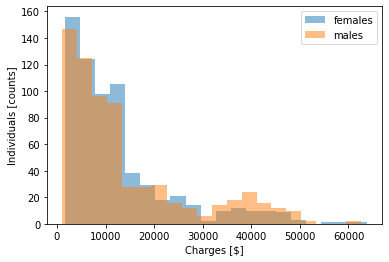

In [ ]:
female = medical_charges['sex'] == 'female'
male = medical_charges['sex'] == 'male'
plt.hist(medical_charges[female]['charges'], bins =20, label = 'females', alpha = 0.5)
plt.hist(medical_charges[male]['charges'], bins =20, label = 'males', alpha = 0.5)
plt.legend()
plt.xlabel('Charges [$]')
plt.ylabel('Individuals [counts]')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Age [years]')

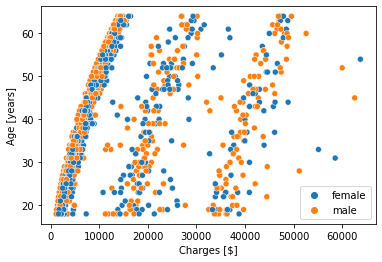

In [ ]:
sns.scatterplot(medical_charges['charges'],medical_charges['age'], hue = medical_charges['sex' ])
plt.legend()
plt.xlabel('Charges [$]')
plt.ylabel('Age [years]')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Age [years]')

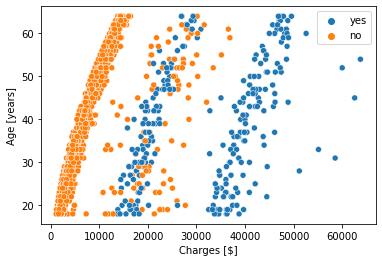

In [ ]:
sns.scatterplot(medical_charges['charges'],medical_charges['age'], hue = medical_charges['smoker' ])
plt.legend()
plt.xlabel('Charges [$]')
plt.ylabel('Age [years]')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Age [years]')

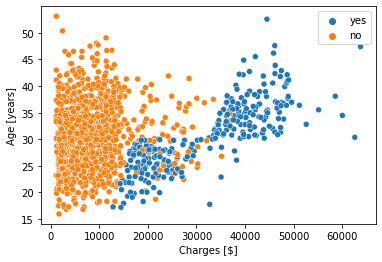

In [ ]:
sns.scatterplot(medical_charges['charges'],medical_charges['bmi'], hue = medical_charges['smoker' ])
plt.legend()
plt.xlabel('Charges [$]')
plt.ylabel('BMI')

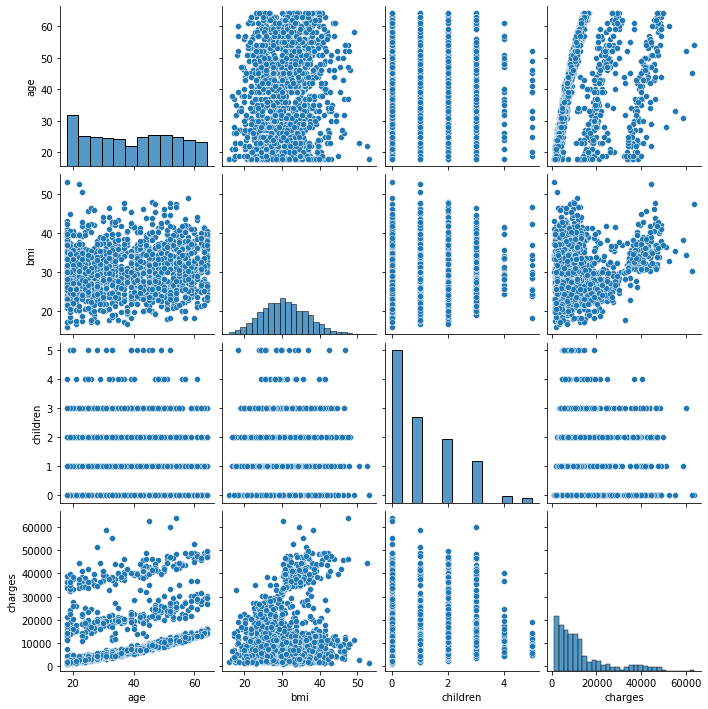

In [ ]:
sns.pairplot(medical_charges)


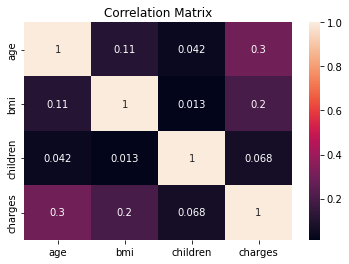

In [ ]:
sns.heatmap(medical_charges.corr(), annot=True)
plt.title('Correlation Matrix');

###  Exercise 2

Find a linear model that predicts the charges based on the parameters you have.

Which is the most important predictor?

Which is the least important predictor?

How much do charges change when a person is a smoker and has BMI >30?

How much does being in the north change the charges?

And what about being in the southwest?



In [ ]:
# don't forget to standardize the quantitative data!
def standardize(x):
  return (x-np.mean(x))/np.std(x)

In [ ]:
medical_charges['age_std'] = standardize(medical_charges['age'])
medical_charges['bmi_std'] = standardize(medical_charges['bmi'])
medical_charges['charges_std'] = standardize(medical_charges['charges'])

In [ ]:
mod = smf.ols(formula='charges_std ~ age_std + sex + bmi_std + children + smoker + region', data=medical_charges)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            charges_std   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     500.8
Date:                Wed, 27 Oct 2021   Prob (F-statistic):               0.00
Time:                        10:25:05   Log-Likelihood:                -968.66
No. Observations:                1338   AIC:                             1955.
Df Residuals:                    1329   BIC:                             2002.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.3914      0.034    -11.528      0.000      -0.458      -0.325
sex[T.male]            -0.0108      0.028     -0.394      0.693      -0.065       0.043
smoker[T.yes]           1.9701      0.034     57.723      0.000       1.903       2.037
region[T.northwest]    -0.0292      0.039     -0.741      0.459      -0.106       0.048
region[T.southeast]    -0.0855      0.040     -2.162      0.031      -0.163      -0.008
region[T.southwest]    -0.0793      0.039     -2.009      0.045      -0.157      -0.002
age_std                 0.2980      0.014     21.587      0.000       0.271       0.325
bmi_std                 0.1708      0.014     11.860      0.000       0.143       0.199
children                0.0393      0.011      3.451      0.001       0.017       0.062
==============================================================================
Omnibus:                      300.366   Durbin-Watson:                   2.088
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              718.887
Skew:                           1.211   Prob(JB):                    7.86e-157
Kurtosis:                       5.651   Cond. No.                         8.53
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
medical_charges['bmi_30'] = np.select([medical_charges['bmi']>=30, medical_charges['bmi']<30],
                                      ['yes', 'no'])

In [ ]:
mod = smf.ols(formula='charges_std ~ age_std + sex + bmi_30 + children + smoker + region', data=medical_charges)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            charges_std   R-squared:                       0.754
Model:                            OLS   Adj. R-squared:                  0.752
Method:                 Least Squares   F-statistic:                     509.1
Date:                Wed, 27 Oct 2021   Prob (F-statistic):               0.00
Time:                        10:53:03   Log-Likelihood:                -960.38
No. Observations:                1338   AIC:                             1939.
Df Residuals:                    1329   BIC:                             1986.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.5880      0.035    -16.593      0.000      -0.657      -0.518
sex[T.male]            -0.0120      0.027     -0.439      0.661      -0.066       0.042
bmi_30[T.yes]           0.3514      0.028     12.608      0.000       0.297       0.406
smoker[T.yes]           1.9689      0.034     58.050      0.000       1.902       2.035
region[T.northwest]    -0.0334      0.039     -0.855      0.393      -0.110       0.043
region[T.southeast]    -0.0476      0.039     -1.235      0.217      -0.123       0.028
region[T.southwest]    -0.0715      0.039     -1.826      0.068      -0.148       0.005
age_std                 0.3017      0.014     22.057      0.000       0.275       0.329
children                0.0398      0.011      3.522      0.000       0.018       0.062
==============================================================================
Omnibus:                      325.633   Durbin-Watson:                   2.091
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              825.447
Skew:                           1.286   Prob(JB):                    5.71e-180
Kurtosis:                       5.863   Cond. No.                         8.70
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# do smoker status and BMI interact?
mod = smf.ols(formula='charges_std ~ age_std + smoker * bmi_30 + children + sex + region', data=medical_charges)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            charges_std   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     927.4
Date:                Wed, 27 Oct 2021   Prob (F-statistic):               0.00
Time:                        10:51:12   Log-Likelihood:                -569.99
No. Observations:                1338   AIC:                             1160.
Df Residuals:                    1328   BIC:                             1212.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      -0.3979      0.027    -14.670      0.000      -0.451      -0.345
smoker[T.yes]                   1.1036      0.037     29.995      0.000       1.031       1.176
bmi_30[T.yes]                   0.0167      0.023      0.717      0.473      -0.029       0.062
sex[T.male]                    -0.0396      0.020     -1.939      0.053      -0.080       0.000
region[T.northwest]            -0.0230      0.029     -0.789      0.430      -0.080       0.034
region[T.southeast]            -0.0485      0.029     -1.683      0.093      -0.105       0.008
region[T.southwest]            -0.0959      0.029     -3.274      0.001      -0.153      -0.038
smoker[T.yes]:bmi_30[T.yes]     1.6403      0.051     32.439      0.000       1.541       1.739
age_std                         0.3080      0.010     30.126      0.000       0.288       0.328
children                        0.0433      0.008      5.121      0.000       0.027       0.060
==============================================================================
Omnibus:                      862.755   Durbin-Watson:                   2.058
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7118.227
Skew:                           3.055   Prob(JB):                         0.00
Kurtosis:                      12.505   Cond. No.                         11.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# does the being in the north changes insurance charges?
conditions = [medical_charges['region'].str.startswith('north'), medical_charges['region'].str.startswith('south')]
choices = ['yes', 'no']
medical_charges['north'] = np.select(conditions, choices)

In [ ]:
mod = smf.ols(formula='charges_std ~ age_std + smoker * bmi_30 + children + sex+ north', data=medical_charges)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            charges_std   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     1191.
Date:                Wed, 27 Oct 2021   Prob (F-statistic):               0.00
Time:                        10:51:26   Log-Likelihood:                -571.68
No. Observations:                1338   AIC:                             1159.
Df Residuals:                    1330   BIC:                             1201.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      -0.4710      0.024    -19.461      0.000      -0.518      -0.424
smoker[T.yes]                   1.1077      0.037     30.149      0.000       1.036       1.180
bmi_30[T.yes]                   0.0203      0.023      0.877      0.380      -0.025       0.066
sex[T.male]                    -0.0394      0.020     -1.928      0.054      -0.080       0.001
north[T.yes]                    0.0599      0.021      2.904      0.004       0.019       0.100
smoker[T.yes]:bmi_30[T.yes]     1.6386      0.051     32.401      0.000       1.539       1.738
age_std                         0.3077      0.010     30.088      0.000       0.288       0.328
children                        0.0427      0.008      5.052      0.000       0.026       0.059
==============================================================================
Omnibus:                      862.384   Durbin-Watson:                   2.061
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7114.309
Skew:                           3.053   Prob(JB):                         0.00
Kurtosis:                      12.504   Cond. No.                         11.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# being in the southwest?
mod = smf.ols(formula='charges_std ~ age_std + \
smoker * bmi_30 + children + sex+ \
C(region, levels =["southwest", "northwest", "southeast", "northeast"])', 
data=medical_charges)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            charges_std   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     927.4
Date:                Wed, 27 Oct 2021   Prob (F-statistic):               0.00
Time:                        11:04:17   Log-Likelihood:                -569.99
No. Observations:                1338   AIC:                             1160.
Df Residuals:                    1328   BIC:                             1212.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=======================================================================================================================================================
                                                                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                              -0.4937      0.028    -17.793      0.000      -0.548      -0.439
smoker[T.yes]                                                                           1.1036      0.037     29.995      0.000       1.031       1.176
bmi_30[T.yes]                                                                           0.0167      0.023      0.717      0.473      -0.029       0.062
sex[T.male]                                                                            -0.0396      0.020     -1.939      0.053      -0.080       0.000
C(region, levels=["southwest", "northwest", "southeast", "northeast"])[T.northwest]     0.0728      0.029      2.491      0.013       0.015       0.130
C(region, levels=["southwest", "northwest", "southeast", "northeast"])[T.southeast]     0.0474      0.029      1.656      0.098      -0.009       0.103
C(region, levels=["southwest", "northwest", "southeast", "northeast"])[T.northeast]     0.0959      0.029      3.274      0.001       0.038       0.153
smoker[T.yes]:bmi_30[T.yes]                                                             1.6403      0.051     32.439      0.000       1.541       1.739
age_std                                                                                 0.3080      0.010     30.126      0.000       0.288       0.328
children                                                                                0.0433      0.008      5.121      0.000       0.027       0.060
==============================================================================
Omnibus:                      862.755   Durbin-Watson:                   2.058
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7118.227
Skew:                           3.055   Prob(JB):                         0.00
Kurtosis:                      12.505   Cond. No.                         11.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Exercise 3

Are there other interactions among features?

What if a separate linear regression for smokers and one for non-smokers is better than a one-size-fits all regression? Test it!

In [ ]:
mod = smf.ols(formula='charges_std ~ (age_std + smoker + bmi_std + children + sex+ region) **2 ', data=medical_charges)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            charges_std   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     214.7
Date:                Wed, 27 Oct 2021   Prob (F-statistic):               0.00
Time:                        10:56:43   Log-Likelihood:                -653.31
No. Observations:                1338   AIC:                             1375.
Df Residuals:                    1304   BIC:                             1551.
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            -0.3721      0.040     -9.314      0.000      -0.450      -0.294
smoker[T.yes]                         2.0200      0.068     29.532      0.000       1.886       2.154
sex[T.male]                          -0.0440      0.050     -0.874      0.382      -0.143       0.055
region[T.northwest]                  -0.0873      0.055     -1.580      0.114      -0.196       0.021
region[T.southeast]                  -0.0723      0.055     -1.320      0.187      -0.180       0.035
region[T.southwest]                  -0.1040      0.054     -1.928      0.054      -0.210       0.002
smoker[T.yes]:sex[T.male]            -0.0022      0.056     -0.040      0.968      -0.112       0.108
smoker[T.yes]:region[T.northwest]    -0.0133      0.080     -0.165      0.869      -0.171       0.145
smoker[T.yes]:region[T.southeast]    -0.0946      0.077     -1.235      0.217      -0.245       0.056
smoker[T.yes]:region[T.southwest]     0.0840      0.082      1.029      0.303      -0.076       0.244
sex[T.male]:region[T.northwest]       0.0316      0.063      0.500      0.617      -0.093       0.156
sex[T.male]:region[T.southeast]       0.0526      0.064      0.826      0.409      -0.072       0.177
sex[T.male]:region[T.southwest]       0.0217      0.064      0.342      0.733      -0.103       0.147
age_std                               0.2642      0.027      9.947      0.000       0.212       0.316
age_std:smoker[T.yes]                -0.0038      0.028     -0.135      0.892      -0.058       0.051
age_std:sex[T.male]                   0.0183      0.022      0.823      0.411      -0.025       0.062
age_std:region[T.northwest]           0.0229      0.032      0.721      0.471      -0.039       0.085
age_std:region[T.southeast]           0.0589      0.032      1.846      0.065      -0.004       0.121
age_std:region[T.southwest]           0.0553      0.032      1.709      0.088      -0.008       0.119
bmi_std                               0.0480      0.028      1.720      0.086      -0.007       0.103
smoker[T.yes]:bmi_std                 0.7490      0.028     26.330      0.000       0.693       0.805
bmi_std:sex[T.male]                   0.0018      0.023      0.077      0.939      -0.044       0.048
bmi_std:region[T.northwest]          -0.0036      0.035     -0.102      0.918      -0.073       0.066
bmi_std:region[T.southeast]          -0.0953      0.031     -3.097      0.002      -0.156      -0.035
bmi_std:region[T.southwest]          -0.0441      0.034     -1.301      0.194      -0.111       0.022
children                              0.0659      0.022      3.034      0.002       0.023       0.109
smoker[T.yes]:children               -0.0318      0.024     -1.337      0.181      -0.078       0.015
children:sex[T.male]   